In [271]:
import pandas as pd
import numpy as np
!pip install pandas_profiling
from pandas_profiling import ProfileReport

# text classification specific libraries
import re
import string
from html import unescape
!pip install spacy
!python -m spacy download en

# visualizations
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [272]:
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 800)

# 1. Import Data

In [273]:
data_location = './data/train.csv'
df = pd.read_csv(data_location)
print('Shape of dataset: ' + str(df.shape) + '\n')
print('Columns in dataset: ' + str(df.columns) + '\n')
print(df.head())

Shape of dataset: (7613, 5)

Columns in dataset: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

   id  ... target
0   1  ...      1
1   4  ...      1
2   5  ...      1
3   6  ...      1
4   7  ...      1

[5 rows x 5 columns]


# 2. EDA

In [274]:
# 2.1 look at properties of dataset
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [275]:
# 2.2 look for null values
columns_in_df = df.columns
for col in columns_in_df:
    print("Nan's in '{}' = {}".format(col, df[col].isna().sum()))

Nan's in 'id' = 0
Nan's in 'keyword' = 61
Nan's in 'location' = 2533
Nan's in 'text' = 0
Nan's in 'target' = 0


In [276]:
# 2.3 pandas_profiling gives a nice profile_report of data
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=False)
# profile

In [277]:
# # Observations:
# 1. 'id' is an auto-incrementing value. Can be set as index or dropped
# 2. 'keyword' has 0.8% (61) missing values. Replace missing values with 'keyword'
# 3. 'location' has 33.3% (2533) missing values. Replace missing values with 'location'
# 4. 'target' is a boolean value. This denotes whether a tweet is about a real disaster (1) or not (0).
#     43% of tweets are disaster related

# 3. Preprocess Data

In [278]:
# 3.1 looks like id is an auto-incrementing value. Set it as index
df.set_index('id', inplace=True)
print(str(df.columns) + '\n')
print(df.head())

Index(['keyword', 'location', 'text', 'target'], dtype='object')

   keyword  ... target
id          ...       
1      NaN  ...      1
4      NaN  ...      1
5      NaN  ...      1
6      NaN  ...      1
7      NaN  ...      1

[5 rows x 4 columns]


In [279]:
# 3.2 replace null/Nan's with strings
df['keyword'].replace(np.nan, 'keyword', inplace=True)
df['location'].replace(np.nan, 'location', inplace=True)

columns_in_df = df.columns
for col in columns_in_df:
    print("After replacing Null values, Nan's in '{}' = {}".format(col, df[col].isna().sum()))

After replacing Null values, Nan's in 'keyword' = 0
After replacing Null values, Nan's in 'location' = 0
After replacing Null values, Nan's in 'text' = 0
After replacing Null values, Nan's in 'target' = 0


In [280]:
# 3.3.1 Look at tweets and see if the text needs to be cleaned
mask = df['target'] == 1
df[mask].loc[0:200]['text']

id
1                                                                               Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
4                                                                                                              Forest fire near La Ronge Sask. Canada
5               All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
6                                                                                   13,000 people receive #wildfires evacuation orders in California 
7                                                            Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
8                                      #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
10                                                    #flood #disaster Heavy rain causes flash fl

In [281]:
# 3.3.2 Look at tweets and see if the text needs to be cleaned
mask = df['target'] == 0
df[mask].loc[0:200]['text']

id
23                                                                                                                                       What's up man?
24                                                                                                                                        I love fruits
25                                                                                                                                     Summer is lovely
26                                                                                                                                    My car is so fast
28                                                                                                                         What a goooooooaaaaaal!!!!!!
31                                                                                                                               this is ridiculous....
32                                                                                   

In [282]:
# Observations:
# -------------
# 1. Remove 11 characters following http://t.co/ 
# 2. Remove all http:, t.co/,  //, /, \n, non-ascii characters, @, (, ), #, &amp;, \, ', ', ", "

In [283]:
# df.loc[[129, 120]].text

# 4 Text data cleaning

### 4.1 Remove any http or https url links from text

In [284]:
example1="test1: http://t.co/UJrX9kgawp this is a text1"
example2="test2: https://t.co/UJrX9kgawp this is a text2"

def remove_URL(text):
    url = re.compile(r'http?://\S+|www\.\S+')
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

print(remove_URL(example1))
print(remove_URL(example2))

test1:  this is a text1
test2:  this is a text2


In [285]:
# df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [286]:
# test
# df.loc[[129, 120]].text

### 4.2 Remove html tags

In [287]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
&nbsp;
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    text = html.sub(r'',text)
    text = unescape(text)
    return text

print(remove_html(example))


Real or Fake
Kaggle 
getting started
 



In [288]:
# df['text'] = df['text'].apply(lambda x: remove_html(x))

In [289]:
# test
# df.loc[[129, 120]].text

### 4.3 Remove Emoji's

In [290]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [291]:
# df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [292]:
# test
# df.loc[129]

### 4.4 Remove punctuations

In [293]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #President"
print(remove_punct(example))

I am a President


In [294]:
# df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [295]:
# test
# df.loc[[129, 120]].text

### 4.5 Remove non-ASCII characters

In [296]:
string_with_ASCII = "àa string withé fuünny charactersß."

def remove_non_ASCII(text):
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return str(decode_string)

print(remove_non_ASCII(string_with_ASCII))

a string with funny characters.


In [297]:
# df['text'] = df['text'].apply(lambda x: remove_non_ASCII(x))

In [298]:
# look at text post processing
# df.loc[[129, 120]].text

### 4.6 Create a TransformerMixin class for pipeline

In [299]:
# Custom transformer to clean text
class TextPreprocessing(TransformerMixin):
    def transform(self, X, **transform_params):
        # Preprocessing Text
        X = [remove_URL(text) for text in X]
        X = [remove_html(text) for text in X]
        X = [remove_emoji(text) for text in X]
        X = [remove_punct(text) for text in X]
        X = [remove_non_ASCII(text) for text in X]
        return X

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

### 4.7 Further cleaning & processing using spaCy

In [300]:
# Reference: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [301]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() 
                if word.lemma_ != "-PRON-" or word.lemma_ != "-PROPN-"
                else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [302]:
# Custom transformer using spaCy
class TextCleaning(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [strip_convert(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def strip_convert(text):
    # Removing spaces and converting sentence into lowercase
    return text.strip().lower()

# 5. Training

In [303]:
# create dictionary with word frequency

# bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

### 5.1 Seperate Data into X & y

In [304]:
# for now using only 'text' column. Depending on the performance, I may pull in 'keyword' & 'location' columns
X = df['text']
y = df['target']
print('shape of X = ' + str(X.shape) + '\n')
print(X.head())
print('\n shape of y = ' + str(y.shape) + '\n')
print(y.head())

shape of X = (7613,)

id
1                                                                    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
4                                                                                                   Forest fire near La Ronge Sask. Canada
5    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
6                                                                        13,000 people receive #wildfires evacuation orders in California 
7                                                 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Name: text, dtype: object

 shape of y = (7613,)

id
1    1
4    1
5    1
6    1
7    1
Name: target, dtype: int64


### 5.2 Split data into train & validation sets

In [305]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

print('shape of X_train = ' + str(X_train.shape))
print('shape of y_train = ' + str(y_train.shape))
print('shape of X_val = ' + str(X_val.shape))
print('shape of y_val = ' + str(y_val.shape))

shape of X_train = (5329,)
shape of y_train = (5329,)
shape of X_val = (2284,)
shape of y_val = (2284,)


In [306]:
print(y_train.isna().sum())
print(y_val.isna().sum())

0
0


In [307]:
text_clean_pipe = Pipeline([
                 ("preprocess", TextPreprocessing()),
                 ])

# generate train dataset
df_train = pd.DataFrame(columns=['text', 'label'])
df_train['label'] = y_train.copy()
df_train['text'] = text_clean_pipe.fit_transform(X_train.copy())

# generate val dataset
df_val = pd.DataFrame(columns=['text', 'label'])
df_val['label'] = y_val.copy()
df_val['text'] = text_clean_pipe.fit_transform(X_val.copy())

# persist the .csv files
df_train.to_csv('./data/split_train.csv')
df_val.to_csv('./data/split_valid.csv')

In [308]:
print(df_train['label'].value_counts())
print(df_val['label'].value_counts())
print(df_train['label'].isna().sum())
print(df_val['label'].isna().sum())
print()

0    3035
1    2294
Name: label, dtype: int64
0    1307
1     977
Name: label, dtype: int64
0
0



### 5.3 Word cloud for disaster & non-disaster tweets

In [309]:
from wordcloud import WordCloud

def create_corpus_df(df, target):
    corpus=[]
    mask_true = df['label']==target
    for x in df[mask_true]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def generate_word_cloud(corpus_to_use):
  plt.clf()
  # Generating the wordcloud with the words in corpus
  plt.figure(figsize=(12,8))
  word_cloud = WordCloud(
                            background_color='black',
                            max_font_size = 80
                          ).generate(" ".join(corpus_to_use))
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.show()

#### 5.3.1 Word Cloud for disaster tweets

<Figure size 432x288 with 0 Axes>

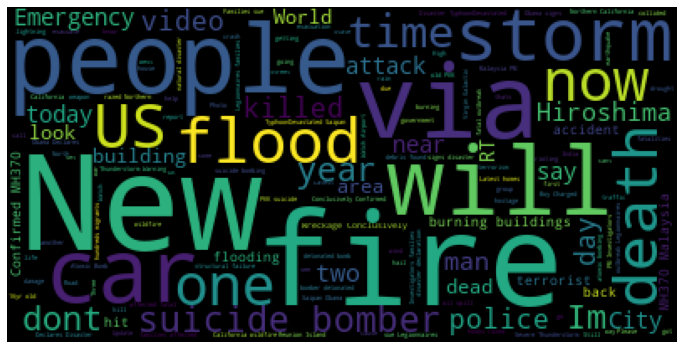

In [310]:
corpus_1 = create_corpus_df(df_train, 1)
generate_word_cloud(corpus_1)

#### 5.3.2 Word Cloud for non-disaster tweets

<Figure size 432x288 with 0 Axes>

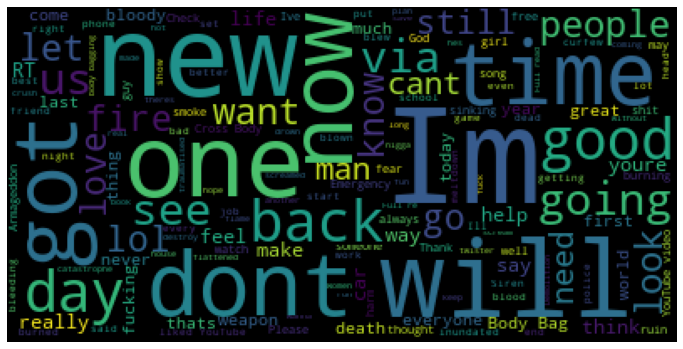

In [311]:
corpus_0 = create_corpus_df(df_train, 0)
generate_word_cloud(corpus_0)

### 5.3 Create a pipeline

In [312]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# GradientBoostingClassifier (not so good performance)
# from sklearn.ensemble import GradientBoostingClassifier
# classifier = GradientBoostingClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([
                 ("preprocess", TextPreprocessing()),
                 ("cleaner", TextCleaning()),
                 ('vectorizer', bow_vector),
#                  ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model training
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 <__main__.TextPreprocessing object at 0x7ff54885dc18>),
                ('cleaner', <__main__.TextCleaning object at 0x7ff54885da20>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngra...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7ff517817ae8>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sca

### 5.4 Predict & Evaluate

In [313]:
from sklearn import metrics
# Predicting with a validation dataset
y_val_predicted = pipe.predict(X_val)

# Model Accuracy
print("Logistic Regression f1_score:",metrics.f1_score(y_val, y_val_predicted))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_val, y_val_predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_val, y_val_predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_val, y_val_predicted))

Logistic Regression f1_score: 0.7440543601359003
Logistic Regression Accuracy: 0.8021015761821366
Logistic Regression Precision: 0.8326996197718631
Logistic Regression Recall: 0.6724667349027635


In [314]:
print(metrics.classification_report(y_val, y_val_predicted,  digits=3))

              precision    recall  f1-score   support

           0      0.786     0.899     0.839      1307
           1      0.833     0.672     0.744       977

    accuracy                          0.802      2284
   macro avg      0.809     0.786     0.791      2284
weighted avg      0.806     0.802     0.798      2284



### 5.5 Visualizations

In [315]:
# Create the confusion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f" tn = {tn} \n fp = {fp} \n fn = {fn} \n tp = {tp}")
    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
# ROC Curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize = (10,7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

 tn = 1175 
 fp = 132 
 fn = 320 
 tp = 657


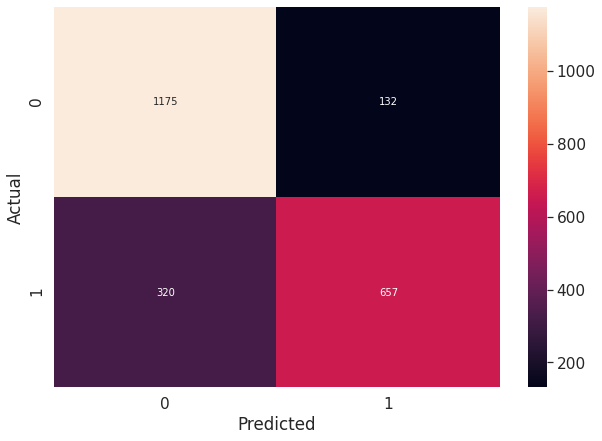

In [316]:
# Confusion Matrix
plot_confussion_matrix(y_val, y_val_predicted)

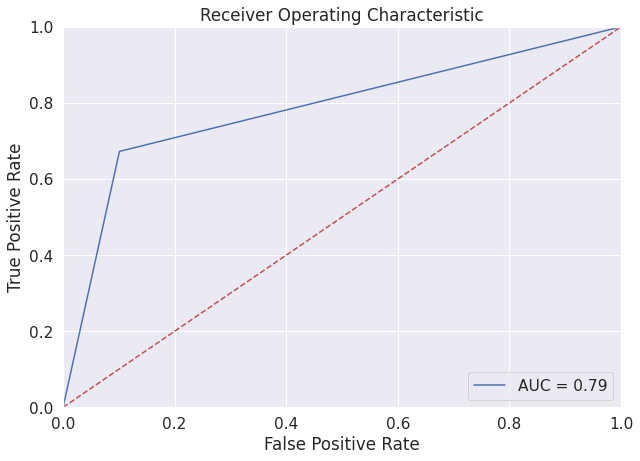

In [317]:
# ROC Curve
plot_roc_curve(y_val, y_val_predicted)

### 5.6 Other Model/s

#### XGBoost (performing similar to LR)

In [318]:
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [319]:
# pipe = Pipeline([
#                  ("preprocess", TextPreprocessing()),
#                  ("cleaner", TextCleaning()),
#                  ('vectorizer', bow_vector),
#                  ('xgbclf', XGBClassifier(early_stopping_rounds=50,
#                                           learning_rate=0.5,
#                                           n_estimators=500,
#                                           eval_metric='logloss',
#                                           verbose=3
#                                           ))])

# # model training
# pipe.fit(X_train, y_train)

# # Predicting with a validation dataset
# y_val_predicted = pipe.predict(X_val)

# # metrics
# print(metrics.classification_report(y_val, y_val_predicted, digits=3))
# print('\n\n')
# print("XGBoost f1_score:",metrics.f1_score(y_val, y_val_predicted))
# print("XGBoost Accuracy:",metrics.accuracy_score(y_val, y_val_predicted))
# print("XGBoost Precision:",metrics.precision_score(y_val, y_val_predicted))
# print("XGBoost Recall:",metrics.recall_score(y_val, y_val_predicted))

In [320]:
# xgb = pipe.named_steps['xgbclf']

XGBoost f1_score: 0.7171270718232045

XGBoost Accuracy: 0.7758318739054291

XGBoost Precision: 0.7744630071599046

XGBoost Recall: 0.6676954732510288
   
              precision    recall  f1-score   support

           0      0.777     0.856     0.814      1312
           1      0.774     0.668     0.717       972

    accuracy                          0.776      2284



#### Hyper parameter tuning

In [321]:
# # Create pipeline using Bag of Words
# pipe = Pipeline([
#                  ("preprocess", TextPreprocessing()),
#                  ("cleaner", TextCleaning()),
#                  ('vectorizer', bow_vector),
#                  ('xgbclf', XGBClassifier())])


# param_grid = {
#     "xgbclf__n_estimators": [10, 50, 100, 500],
#     "xgbclf__learning_rate": [0.1, 0.5, 1],
#     "xgbclf__verbose": True
# }

# fit_params = {"xgbclf__eval_set": [(X_val, y_val)], 
#               "xgbclf__early_stopping_rounds": 50, 
#               "xgbclf__verbose": True} 

# searchCV = GridSearchCV(pipe, cv=5, param_grid=param_grid)
# searchCV.fit(X_train, y_train, **fit_params)

# print(searchCV.best_params_)
# #### print(searchCV.cv_results_['mean_train_score'])
# print(searchCV.cv_results_['mean_test_score'])

# 6. Generate test predictions for Kaggle submission

In [322]:
test_data_location = './data/test.csv'
test_df = pd.read_csv(test_data_location)
print('Shape of dataset: ' + str(test_df.shape) + '\n')
print('Columns in dataset: ' + str(test_df.columns) + '\n')
print(test_df.head())

Shape of dataset: (3263, 4)

Columns in dataset: Index(['id', 'keyword', 'location', 'text'], dtype='object')

   id  ...                                                                                              text
0   0  ...                                                                Just happened a terrible car crash
1   2  ...                                  Heard about #earthquake is different cities, stay safe everyone.
2   3  ...  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
3   9  ...                                                          Apocalypse lighting. #Spokane #wildfires
4  11  ...                                                     Typhoon Soudelor kills 28 in China and Taiwan

[5 rows x 4 columns]


In [323]:
# get predictions
X_test = test_df['text']
y_test_predicted = pipe.predict(X_test)

In [324]:
result_df = pd.DataFrame(columns=['id', 'target'])
result_df['id'] = test_df['id'].copy()
result_df['target'] = y_test_predicted
print(result_df.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1


In [325]:
result_df.to_csv('./data/submission_baseline.csv', index=False)

# 7. Word Embeding & GloVe Implementation

In [326]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

# to hold index of the dataset
INDEX = data.Field(sequential=False, use_vocab=False, dtype=torch.int64)

In [327]:
#reference: https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

from torchtext.data import TabularDataset

tv_datafields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("text", TEXT),
                 ("label", LABEL)]

# define train & validation datasets
trn, vld = TabularDataset.splits(
               path="data", # the root directory where the data lies
               train='split_train.csv', validation="split_valid.csv",
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=tv_datafields)

# define test data set
tst_datafields = [("id", INDEX), # if we won't need the id, we need to pass None as the field
                  ("text", TEXT)]
tst = TabularDataset(
           path="data/test.csv", # the file path
           format='csv',
           skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
           fields=tst_datafields)

we'll view how many examples are in each split.

In [328]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of validation examples: {len(vld)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 5329
Number of validation examples: 2284
Number of testing examples: 3263


In [329]:
# take a look at dataset
print(trn[0])
print(trn[0].__dict__.keys())
print(trn[0].text[0:3])

dict_keys(['text', 'label'])
['California', 'LawNegligence', 'and']


In [330]:
# take a look at test dataset
print(tst[0])
print(tst[0].__dict__.keys())
# print(tst[3].id)

dict_keys(['id', 'text'])


The following builds the vocabulary, only keeping the most common max_size tokens.

In [331]:
# build volcabulary using training dataset
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(trn, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(trn)

Why do we only build the vocabulary on the training set? When testing any machine learning system you do not want to look at the test set in any way. We do not include the validation set as we want it to reflect the test set as much as possible.

In [332]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 17249
Unique tokens in LABEL vocabulary: 2


We can also view the most common words in the vocabulary and their frequencies.

In [333]:
print(TEXT.vocab.freqs.most_common(20))

[(' ', 2332), ('the', 1763), ('a', 1307), ('in', 1242), ('to', 1234), ('of', 1188), ('I', 1040), ('and', 912), ('for', 602), ('on', 581), ('is', 567), ('you', 513), ('The', 420), ('my', 385), ('with', 376), ('that', 369), ('at', 344), ('by', 338), ('nt', 336), ('\n', 322)]


In [334]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7ff548dda0d0>, {'0': 0, '1': 1})


## Word Embedding

In [335]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [336]:
embeds = nn.Embedding(len(TEXT.vocab), 10)  # number of words in vocab, 10 dimensional embeddings
lookup_tensor = torch.tensor(TEXT.vocab.stoi['hello'], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([ 0.0769, -0.4999,  0.2286,  0.0104,  0.8167, -0.0740, -0.6547,  0.5372,
        -1.6523,  0.3434], grad_fn=<EmbeddingBackward>)


### Logistic Regression

In [337]:
class LR(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
       
        embedded = self.embedding(text)     

        hidden = torch.mean(embedded, dim=0)
        
        return self.fc(hidden)

In [338]:
cuda_device = torch.device('cuda')
BATCH_SIZE = 64

In [339]:
from torchtext.data import Iterator, BucketIterator

train_iter, val_iter = BucketIterator.splits(
                      (trn, vld), # we pass in the datasets we want the iterator to draw data from
                      batch_sizes=(64, 64),
                      device=cuda_device, # if you want to use the GPU, specify the GPU number here
                      sort=False,
                      sort_within_batch=False,
                      repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
                      )

test_iter = Iterator(tst, 
                     batch_size=len(tst), 
                     device=cuda_device,
                     train=False,
                     shuffle = False, 
                     sort=False, 
                     sort_within_batch=False, 
                     repeat=False)

In [340]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1

model = LR(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)

### Train the Model

In [341]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(cuda_device)
criterion = criterion.to(cuda_device)

In [342]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [343]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [344]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [345]:
def predict_test(model, iterator):
    model.eval()
    predictions = []
    index = []
    with torch.no_grad():
        for batch in iterator:
            pred_batch = model(batch.text).squeeze(1)
            print(batch)
            predictions += torch.round(torch.sigmoid(pred_batch))
            index.append(batch.id)
        
    return predictions, index

In [346]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [347]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lr-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.678 | Train Acc: 57.07%
	 Val. Loss: 0.671 |  Val. Acc: 57.82%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.660 | Train Acc: 59.47%
	 Val. Loss: 0.654 |  Val. Acc: 66.17%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.637 | Train Acc: 64.95%
	 Val. Loss: 0.630 |  Val. Acc: 66.65%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.603 | Train Acc: 70.72%
	 Val. Loss: 0.601 |  Val. Acc: 70.49%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.562 | Train Acc: 77.01%
	 Val. Loss: 0.574 |  Val. Acc: 71.29%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.515 | Train Acc: 80.07%
	 Val. Loss: 0.545 |  Val. Acc: 74.04%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.473 | Train Acc: 82.32%
	 Val. Loss: 0.520 |  Val. Acc: 76.71%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.435 | Train Acc: 84.78%
	 Val. Loss: 0.503 |  Val. Acc: 77.94%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.398 | Train Acc: 86.23%
	 Val. Loss: 0.489 |  Val. Acc: 78.99%
Epoch: 10 | Epoch Time: 0m 0

In [348]:
# load model
model.load_state_dict(torch.load('lr-model.pt'))
# make predictions
predictions, index = predict_test(model, test_iter)


[torchtext.data.batch.Batch of size 3263]
	[.id]:[torch.cuda.LongTensor of size 3263 (GPU 0)]
	[.text]:[torch.cuda.LongTensor of size 1x3263 (GPU 0)]


In [349]:
print(len(predictions))
print(len(index[0]))

3263
3263


In [350]:
result_df = pd.DataFrame(columns=['id', 'target'])
y_test_pred = pd.Series([x.cpu().numpy() for x in predictions])
id = [x.cpu().numpy() for x in index]
result_df['id'] = pd.Series(id[0])
result_df['target'] = y_test_pred
result_df['target'] = result_df['target'].apply(lambda x: int(x))

In [351]:
result_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [352]:
# save results
result_df.to_csv('./data/submission_baseline_2.csv', index=False)

## Use pre-trained word embedding

Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the "glove.6B.100d" vectors". glove is the algorithm used to calculate the vectors, go [here](https://nlp.stanford.edu/projects/glove/) for more. 6B indicates these vectors were trained on 6 billion tokens and 100d indicates these vectors are 100-dimensional.

You can see the other available vectors [here](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113).

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

Note: these vectors are about 862MB, so watch out if you have a limited internet connection.

By default, TorchText will initialize words in your vocabulary but not in your pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting unk_init to torch.Tensor.normal_. This will now initialize those words via a Gaussian distribution.

In [353]:
MAX_VOCAB_SIZE = 25000

# TEXT = data.Field(tokenize = 'spacy')
# LABEL = data.LabelField(dtype = torch.float)

TEXT.build_vocab(trn, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(trn)

In [354]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([17249, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

Note: this should always be done on the weight.data and not the weight!

In [355]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.2181,  0.8857, -0.4670,  ...,  0.3317,  0.4628, -1.0435],
        [ 0.2902,  0.5470, -0.0526,  ..., -1.0951,  0.6313, -0.7725],
        [-0.2790, -0.3981, -0.7106,  ..., -0.2976, -0.1067,  0.2735],
        ...,
        [-1.6999,  0.6130,  0.4049,  ..., -1.3136,  1.3715,  1.1047],
        [ 0.1367, -0.1832, -0.0628,  ...,  0.1960,  0.2462,  0.1169],
        [ 0.4593,  0.0251,  0.0319,  ..., -0.0136, -0.5006,  0.5798]],
       device='cuda:0')

In [356]:
# BASELINE
class LR(nn.Module):
    def __init__(self, vocab, input_dim, embedding_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors)
        # self.embedding.weight.requires_grad = False
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
       
        embedded = self.embedding(text)     

        hidden = torch.mean(embedded, dim=0)
        
        return self.fc(hidden)

In [357]:
class MLP(nn.Module):
    def __init__(self, vocab, input_dim, embedding_dim, output_dim):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors)
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim, 70),
            nn.ReLU(),
            nn.Linear(70, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, output_dim)
        )

    def forward(self, text):
        embedded = self.embedding(text)     
        hidden = torch.mean(embedded, dim=0)
        xb = self.layers(hidden)
        # xb = self.layers(embedded)
        return xb

In [358]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1

# model = LR(TEXT.vocab, INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)
model = MLP(TEXT.vocab, INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(cuda_device)
criterion = criterion.to(cuda_device)

In [359]:
model.parameters

<bound method Module.parameters of MLP(
  (embedding): Embedding(17249, 100)
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=70, bias=True)
    (1): ReLU()
    (2): Linear(in_features=70, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=True)
  )
)>

In [360]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lr-model_with_pre_trained_wv.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.679 | Train Acc: 56.39%
	 Val. Loss: 0.664 |  Val. Acc: 57.30%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.612 | Train Acc: 68.29%
	 Val. Loss: 0.598 |  Val. Acc: 68.23%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.498 | Train Acc: 78.23%
	 Val. Loss: 0.580 |  Val. Acc: 70.10%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.397 | Train Acc: 83.21%
	 Val. Loss: 0.635 |  Val. Acc: 69.84%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.325 | Train Acc: 87.12%
	 Val. Loss: 0.632 |  Val. Acc: 71.66%


In [361]:
# load model
model.load_state_dict(torch.load('lr-model_with_pre_trained_wv.pt'))
# make predictions
predictions, index = predict_test(model, test_iter)
# prepare DF
result_df = pd.DataFrame(columns=['id', 'target'])
y_test_pred = pd.Series([x.cpu().numpy() for x in predictions])
id = [x.cpu().numpy() for x in index]
result_df['id'] = pd.Series(id[0])
result_df['target'] = y_test_pred
#
result_df['target'] = result_df['target'].apply(lambda x: int(x))
print(result_df.head())
# save submission file
result_df.to_csv('./data/submission_3.csv', index=False)


[torchtext.data.batch.Batch of size 3263]
	[.id]:[torch.cuda.LongTensor of size 3263 (GPU 0)]
	[.text]:[torch.cuda.LongTensor of size 1x3263 (GPU 0)]
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0


References: 

https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html

